$\color{yellow}{\text{Importy niezbędnych bibliotek}}$

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

$\color{yellow}{\text{Zadanie 1}}$

Definiujemy funkcje, które będziemy badać

In [2]:
x, y = sp.symbols('x y')

f1 = x**2 - 4*x*y + y**2
f2 = x**4 - 4*x*y + y**4
f3 = 2*x**3 - 3*x**2 - 6*x*y*(x - y - 1)
f4 = (x - y)**4 + x**2 - y**2 - 2*x + 2*y + 1

functions = [f1, f2, f3, f4]

Funkcja znajdująca punkty stacjonarne

In [3]:
def find_critical_points(f):
    f_x = sp.diff(f, x)
    f_y = sp.diff(f, y)

    critical_points = sp.solve([f_x, f_y], (x, y))

    if isinstance(critical_points, dict):
        critical_points = [tuple(critical_points.values())]
        
    return [point for point in critical_points if all(sp.im(part) == 0 for part in point)]

Funkcja klasyfikująca punkty krytyczne/stacjonarne

In [4]:
def classify_critical_points(f):
    critical_points = find_critical_points(f)
    
    local_min = []
    local_max = []
    saddle = []
    
    hessian_matrix = sp.hessian(f, (x, y))
    
    for point in critical_points:
        hessian_at_point = hessian_matrix.subs({x: point[0], y: point[1]})
        eigenvalues = hessian_at_point.eigenvals()
        
        if all(sp.im(eigenvalue) == 0 for eigenvalue in eigenvalues):
            real_eigenvalues = [eigenvalue.evalf() for eigenvalue in eigenvalues]
            if all(eigenvalue > 0 for eigenvalue in real_eigenvalues):
                local_min.append(point)
            elif all(eigenvalue < 0 for eigenvalue in real_eigenvalues):
                local_max.append(point)
            else:
                saddle.append(point)
        else:
            saddle.append(point)

    return local_min, local_max, saddle

Wyniki: ekstrema lokalne i punkty siodłowe

In [5]:
for i, f in enumerate(functions):
    print(f'Function {i + 1}:')
    local_min, local_max, saddle = classify_critical_points(f)
    print(f'Local minima: {local_min}')
    print(f'Local maxima: {local_max}')
    print(f'Saddle points: {saddle}')
    print()

Function 1:
Local minima: []
Local maxima: []
Saddle points: [(0, 0)]

Function 2:
Local minima: [(-1, -1), (1, 1)]
Local maxima: []
Saddle points: [(0, 0)]

Function 3:
Local minima: [(1, 0)]
Local maxima: [(-1, -1)]
Saddle points: [(0, -1), (0, 0)]

Function 4:
Local minima: []
Local maxima: []
Saddle points: [(1, 1)]



Funkcja badająca istnienie globalnych minimów i maksimów

In [6]:
def check_global_extrema(f):
    critical_points = find_critical_points(f)
    values_at_critical_points = [f.subs({x: point[0], y: point[1]}) for point in critical_points]
    
    limits = [sp.limit(f, var, lim) for var, lim in [(x, sp.oo), (x, -sp.oo), (y, sp.oo), (y, -sp.oo)]]
    
    all_values = values_at_critical_points + limits
    
    numerical_values = [val for val in all_values if val.is_real and not val.has(sp.oo, -sp.oo)]
    
    if numerical_values:
        global_min = min(numerical_values)
        global_max = max(numerical_values)
    else:
        global_min, global_max = None, None

    if any(val == sp.oo or val == -sp.oo for val in limits):
        if all(val == sp.oo for val in limits):
            global_min = None
        elif all(val == -sp.oo for val in limits):
            global_max = None
    
    return global_min, global_max

Wyniki: globalne ekstrema

In [7]:
for i, f in enumerate(functions):
    print(f'Function {i + 1}:')
    
    global_min, global_max = check_global_extrema(f)
    print(f'Global minimum: {global_min}')
    print(f'Global maximum: {global_max}')
    print()

Function 1:
Global minimum: None
Global maximum: 0

Function 2:
Global minimum: None
Global maximum: 0

Function 3:
Global minimum: -1
Global maximum: 1

Function 4:
Global minimum: None
Global maximum: 1



$\color{yellow}{\text{Zadanie 2}}$

Zadajemy przykładowe parametry

In [8]:
n = 20
k = 50
x_start = np.array([0, 0])
x_end = np.array([20, 20])
r = np.random.uniform(0, 20, (k, 2))
lambda_1 = 1
lambda_2 = 1
epsilon = 1e-13
iterations = 400

Funkcje celu i gradientu funkcji celu

In [9]:
def objective_function(X):
    term1 = lambda_1 * np.sum([1 / (epsilon + np.linalg.norm(X[i] - r[j])**2) for i in range(n) for j in range(1, k)])
    term2 = lambda_2 * np.sum([np.linalg.norm(X[i+1] - X[i])**2 for i in range(n-1)])
    return term1 + term2

def gradient(X):
    grad = np.zeros_like(X)
    for i in range(1, n):
        grad_term1 = np.sum([-2 * (X[i] - r[j]) / (epsilon + np.linalg.norm(X[i] - r[j])**2)**2 for j in range(k)], axis=0)
        grad_term2 = 2 * (X[i] - X[i-1]) + 2 * (X[i] - X[i+1])
        grad[i] = lambda_1 * grad_term1 + lambda_2 * grad_term2
        
        grad[0] = np.zeros(2)
        grad[n] = np.zeros(2)
    return grad

Algorytm największego spadku z przeszukiwaniem liniowym

In [10]:
def golden_section_search(f, a, b, tol=1e-5):
    invphi = (np.sqrt(5) - 1) / 2
    invphi2 = (3 - np.sqrt(5)) / 2
    h = b - a
    if h <= tol:
        return (a + b) / 2

    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))
    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)

    for k in range(n - 1):
        if yc < yd:
            b = d
            d = c
            c = a + invphi2 * (b - a)
            yd = yc
            yc = f(c)
        else:
            a = c
            c = d
            d = a + invphi * (b - a)
            yc = yd
            yd = f(d)

    if yc < yd:
        return (a + d) / 2
    else:
        return (c + b) / 2

def line_search(X, grad, alpha=1, tol=1e-5):
    f = lambda a: objective_function(X - a * grad)
    return golden_section_search(f, 0, alpha, tol)

Losowa inicjalizacjia przeszkód

In [11]:
# Inicjalizacja pozycji x losowo
x_init = np.random.uniform(0, 20, (n+1, 2))
x_init[0] = x_start
x_init[n] = x_end

In [18]:
X = x_init.copy()
objective_values = []
for _ in range(iterations):
    grad = gradient(X)
    alpha = line_search(X, grad)
    X -= alpha * grad
    objective_values.append(objective_function(X))

print(f'Koncowa wartosc funkcji celu: {objective_values[-1]}')

Koncowa wartosc funkcji celu: 68.6353163331217


Wizualizacja wyników

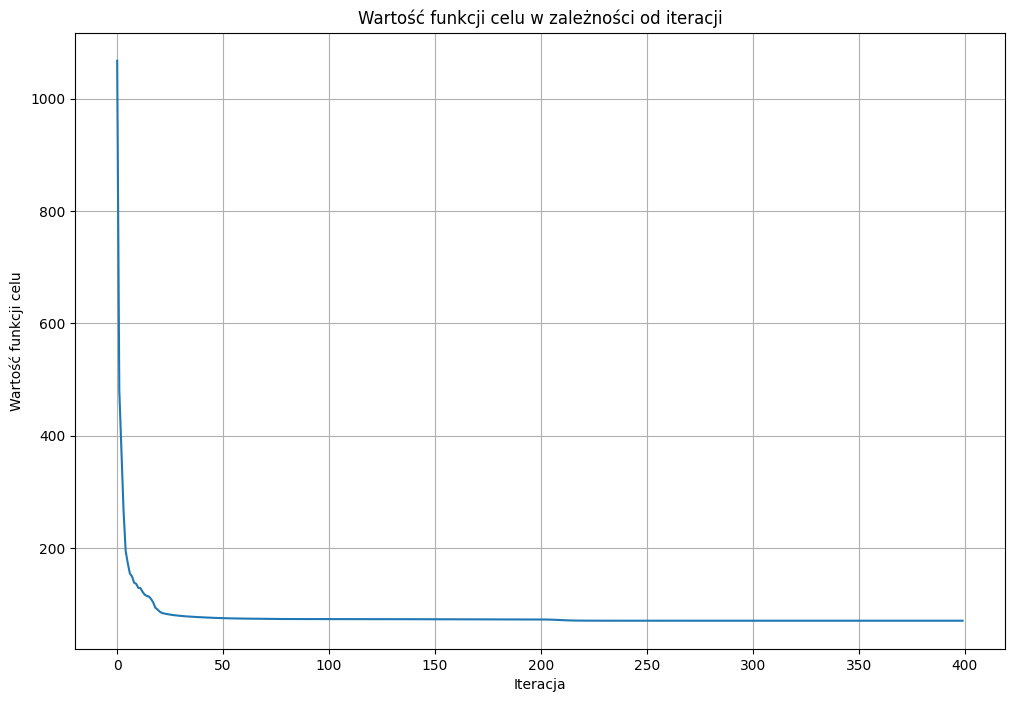

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(objective_values)
plt.xlabel('Iteracja')
plt.ylabel('Wartość funkcji celu')
plt.title('Wartość funkcji celu w zależności od iteracji')
plt.grid()
plt.show()    

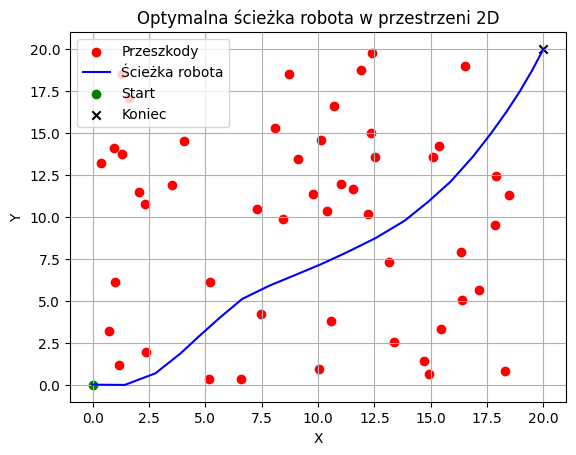

In [15]:
plt.figure()
plt.scatter(r[:, 0], r[:, 1], c='red', label='Przeszkody')
plt.plot(X[:, 0], X[:, 1], c='blue', label='Ścieżka robota')
plt.scatter(X[0, 0], X[0, 1], c='green', marker='o', label='Start')
plt.scatter(X[-1, 0], X[-1, 1], c='black', marker='x', label='Koniec')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Optymalna ścieżka robota w przestrzeni 2D')
plt.legend()
plt.grid(True)
plt.show()